In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Heat loss
def heat_loss(x1, x2, x3):
    Q = 1 / x1 + 1.5 / x2  + 2.0 / x3
    return Q

In [2]:
# Generate training dataset
n_row = 50
n_col = 50
n_samples = n_row * n_col

x1 = torch.zeros(n_samples, 1)
x2 = torch.zeros(n_samples, 1)
x3 = torch.zeros(n_samples, 1)

x1_min, x1_max = 0.05, 0.25

for i in range(n_samples):
    row = int(i / n_col)
    col = i - row * n_col
    x1[i] = row * (x1_max - x1_min) / n_row + x1_min
    
    x2_min = 0.05
    x2_max = 0.6 - 2 * x1[i] - 0.05
    x2[i] =  col * (x2_max - x2_min) / n_col + x2_min
    
    x3[i] = 1.5 - 5 * x1[i] - 2.5 * x2[i]

x3_min = min(x3)
x3_max = max(x3)

In [3]:
# Normalize inputs and outputs
def normalize(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min)

def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Normalize data
x1_norm = normalize(x1, x1_min, x1_max)
x2_norm = normalize(x2, x2_min, x2_max)
x3_norm = normalize(x3, x3_min, x3_max)
Q = heat_loss(x1, x2, x3)
Q_min, Q_max = Q.min(), Q.max()  # Save for denormalization
Q_norm = normalize(Q, Q_min, Q_max)

In [4]:
# Combine normalized inputs into a single tensor
inputs_norm = torch.cat((x1_norm, x2_norm), dim=1)
outputs_norm = Q_norm.view(-1, 1)

Epoch [200/10000], Loss: 0.00203
Epoch [400/10000], Loss: 0.00066
Epoch [600/10000], Loss: 0.00028
Epoch [800/10000], Loss: 0.00021
Epoch [1000/10000], Loss: 0.00020
Epoch [1200/10000], Loss: 0.00026
Epoch [1400/10000], Loss: 0.00020
Epoch [1600/10000], Loss: 0.00015
Epoch [1800/10000], Loss: 0.00015
Epoch [2000/10000], Loss: 0.00011
Epoch [2200/10000], Loss: 0.00011
Epoch [2400/10000], Loss: 0.00012
Epoch [2600/10000], Loss: 0.00008
Epoch [2800/10000], Loss: 0.00014
Epoch [3000/10000], Loss: 0.00009
Epoch [3200/10000], Loss: 0.00006
Epoch [3400/10000], Loss: 0.00008
Epoch [3600/10000], Loss: 0.00005
Epoch [3800/10000], Loss: 0.00005
Epoch [4000/10000], Loss: 0.00004
Epoch [4200/10000], Loss: 0.00010
Epoch [4400/10000], Loss: 0.00004
Epoch [4600/10000], Loss: 0.00005
Epoch [4800/10000], Loss: 0.00004
Epoch [5000/10000], Loss: 0.00004
Epoch [5200/10000], Loss: 0.00004
Epoch [5400/10000], Loss: 0.00004
Epoch [5600/10000], Loss: 0.00003
Epoch [5800/10000], Loss: 0.00007
Epoch [6000/10000]

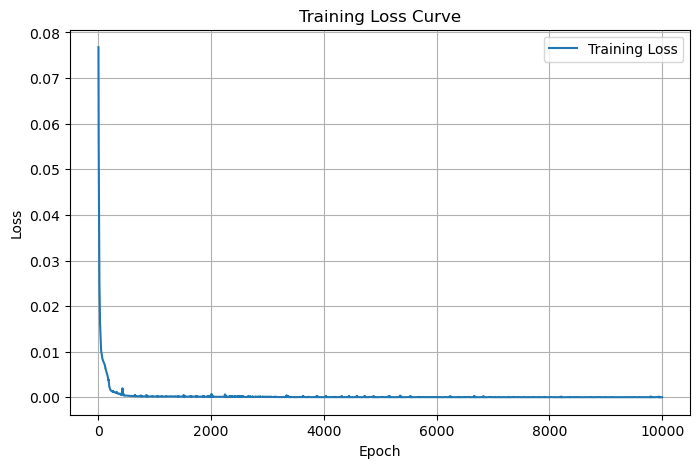

In [5]:
# Define a neural network model
class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SurrogateModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Train the model
n_epochs = 10000
loss_history = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(inputs_norm)
    loss = criterion(predictions, outputs_norm)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.5f}')

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Initial guess for optimization
x_opt = torch.tensor([0.5, 0.5], requires_grad=True)

# Optimizer for the optimization process
optimizer = optim.Adam([x_opt], lr=0.2)

# Optimization loop
n_iterations = 4000
for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    # Predict normalized Q
    Q_pred_norm = model(x_opt)
    Q_pred = denormalize(Q_pred_norm, Q_min, Q_max)  # Denormalize for penalty calculation
    
    # Denormalize inputs
    x1_denorm = denormalize(x_opt[0], x1_min, x1_max)
    x2_denorm = denormalize(x_opt[1], x2_min, x2_max)
    
    # Loss for minimization
    loss = Q_pred
    loss.backward()
    optimizer.step()
    
    if (iteration + 1) % 500 == 0:
        print(f'Iteration [{iteration + 1}/{n_iterations}], Predicted Q: {Q_pred.item():.4f}, x_opt: {x_opt.data.numpy()}')

# Final optimized values (denormalized)
x1_opt = denormalize(x_opt[0].detach(), x1_min, x1_max)
x2_opt = denormalize(x_opt[1].detach(), x2_min, x2_max)

print(f'x1= {x1_opt.item():.2f}')
print(f'x2= {x2_opt.item():.2f}')
print(f'x3= {1.5 - 5 * x1_opt.item() - 2.5 * x2_opt.item():.2f}')

Iteration [500/4000], Predicted Q: 20.7006, x_opt: [ 0.4106013 18.777946 ]
Iteration [1000/4000], Predicted Q: 20.6171, x_opt: [ 0.3836431 19.502686 ]
Iteration [1500/4000], Predicted Q: 20.8769, x_opt: [ 0.34122032 19.613611  ]
Iteration [2000/4000], Predicted Q: 20.9579, x_opt: [ 0.3562958 19.694662 ]
Iteration [2500/4000], Predicted Q: 21.0698, x_opt: [ 0.3140097 19.417683 ]
Iteration [3000/4000], Predicted Q: 20.7881, x_opt: [ 0.38905743 19.54962   ]
Iteration [3500/4000], Predicted Q: 20.9723, x_opt: [ 0.32790485 19.59268   ]
Iteration [4000/4000], Predicted Q: 20.8743, x_opt: [ 0.37399292 19.422583  ]
x1= 0.12
x2= 0.21
x3= 0.36
